# Intro

## Load and import CapsNet

First, let's clone our GitHub repo and import all parts which will be used in this notebook.

In [1]:
!pip install git+https://github.com/tumido/face_biometrics_descriptor-code.git

from sklearn.datasets import fetch_lfw_people
from capsnet import preprocess_lfw_people, CapsNet

  Cloning https://github.com/tumido/face_biometrics_descriptor-code.git to /tmp/pip-req-build-ihpuzj7q
  Stored in directory: /tmp/pip-ephem-wheel-cache-cu4nf7zp/wheels/4b/a7/58/b3478a3941f54e41b3d1461c27bdd21d9d1aea4719811f7746
Successfully built capsnet


Using TensorFlow backend.


## Auxilary imports

Additional imports used in this Notebook would help to visualize data.

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

## Verify GPU

in the next cell we verify that a GPU is available to our use. The output should contain a `Tesla K80` GPU.

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 231443036070779311, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14441555638603040235
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18162430666935898592
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13823495334354001618
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## Collect data set 

We're gonna be working with LFW dataset

In [0]:
people = fetch_lfw_people(
    color=True,
    min_faces_per_person=40
)


data = preprocess_lfw_people(people)
(x_train, y_train), (x_test, y_test) = data

In [11]:
metrics = [
    ["Identities", len(np.unique(people.target, axis=0))],
    ["Total images", people.target.shape[0]],
    ["Train images", len(y_train)],
    ["Test images", len(y_test)],
    ["Image shape", x_train.shape[1:]]
]
pd.DataFrame(metrics, columns=["Name", "Value"])

,Name,Value
0,Identities,19
1,Total images,1867
2,Train images,1493
3,Test images,374
4,Image shape,"(32, 32, 3)"


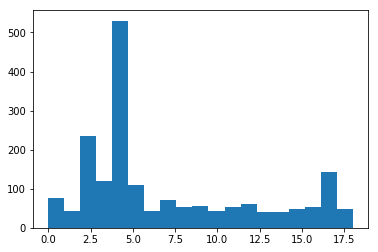

In [12]:
_ = plt.hist(people.target, bins=people.target_names.shape[0])

4: George W Bush


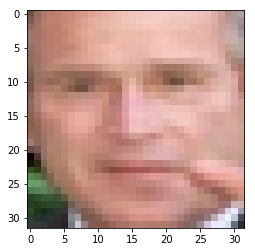

In [13]:
i = randint(0, len(x_train))
plt.imshow(x_train[i])
print("{}: {}".format(np.argmax(y_train[i]), people.target_names[np.argmax(y_train[i])]))

## CapsNet

Let's begin training our network

In [14]:
capsnet = CapsNet(
    x_train.shape[1:],
    len(np.unique(y_train, axis=0))
)
capsnet.models['train'].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv2d (Conv2D)         (None, 24, 24, 256)  62464       input_image[0][0]                
__________________________________________________________________________________________________
encoder_feature_caps_conv2d (Co (None, 8, 8, 256)    5308672     encoder_conv2d[0][0]             
__________________________________________________________________________________________________
encoder_feature_caps_reshape (R (None, 2048, 8)      0           encoder_feature_caps_conv2d[0][0]
__________________________________________________________________________________________________
encoder_fe

In [15]:
history = capsnet.train(data, batch_size=10)

Epoch 1/100
150/149 [==============================] - 23s 156ms/step - loss: 9.5235 - capsnet_loss: 1.3661 - decoder_loss: 16314.8271 - capsnet_acc: 0.2447 - val_loss: 4.4520 - val_capsnet_loss: 1.1664 - val_decoder_loss: 6571.2750 - val_capsnet_acc: 0.2754

Epoch 00001: val_capsnet_acc improved from -inf to 0.27540, saving model to model/weights.01.h5
Epoch 2/100
150/149 [==============================] - 23s 152ms/step - loss: 3.0037 - capsnet_loss: 0.7999 - decoder_loss: 4407.5821 - capsnet_acc: 0.2896 - val_loss: 2.7175 - val_capsnet_loss: 0.7577 - val_decoder_loss: 3919.7584 - val_capsnet_acc: 0.2754

Epoch 00002: val_capsnet_acc did not improve from 0.27540
Epoch 3/100
150/149 [==============================] - 24s 158ms/step - loss: 2.5962 - capsnet_loss: 0.6960 - decoder_loss: 3800.2891 - capsnet_acc: 0.3124 - val_loss: 2.6258 - val_capsnet_loss: 0.7002 - val_decoder_loss: 3851.1806 - val_capsnet_acc: 0.3155

Epoch 00003: val_capsnet_acc improved from 0.27540 to 0.31551, savin

## Results of training

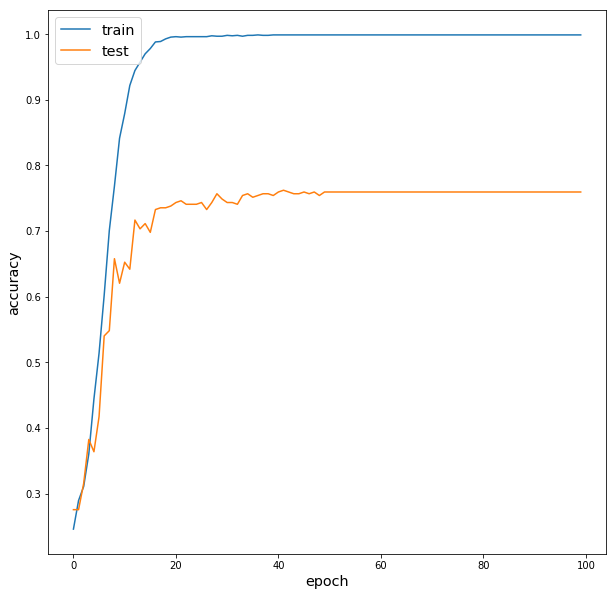

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['capsnet_acc'])
plt.plot(history.history['val_capsnet_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')